### DHL Inventory Optimization Project - EDA, Data cleaning, and Hypothesis Testing

#### Import required Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import poisson, nbinom, entropy, chisquare, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline
print("Full DHL optimization Notebook Loaded")

Full DHL optimization Notebook Loaded


#### 1. Data loading and Initial Understanding

In [5]:
df = pd.read_parquet(r'DHL_Project.parquet')

# Simple statsistics about the dataframe
def data_statistics(data):
    print("# Simple Statistics about the data.....")
    print("-" * 50)
    
    # Corrected Shape access
    print(f"Shape: {data.shape[0]} Rows, {data.shape[1]} Columns")
    print("-" * 50)

    # Columns
    print(f"Columns list: {data.columns.tolist()}")
    print("-" * 50)

    print("# Data types:")
    print(data.dtypes)  # Attribute, no parentheses
    print("-" * 50)

    total_memory = data.memory_usage(deep=True).sum() / 1024**2
    print(f"# Total Memory Usage: {total_memory:.2f} MB")
    print("-" * 50)
    
    # Use display() for a pretty table in Notebooks
    print(f"# Statistical Summary:\n{data.describe(include = 'all')}")
    print("-" * 50)

    # First 5 Rows of dataframe
    print(data.head())
    

data_statistics(df)

# Simple Statistics about the data.....
--------------------------------------------------
Shape: 180519 Rows, 53 Columns
--------------------------------------------------
Columns list: ['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id', 'Customer Lname', 'Customer Password', 'Customer Segment', 'Customer State', 'Customer Street', 'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'Order Customer Id', 'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Region', 'Order State', 'Or

#### Summary
- The dataset have 1,80,519 observations (rows), and total of 53 columns
- We have seen all the column names, and the data types of that columns are displayed in the output.
- We can see the Statistical summary about the dataset, and first 5 rows of dataset was also we can see in the output

In [7]:
# Summary stats key variables
key_vars = ['Days for shipping (real)', 'Days for shipment (scheduled)',
            'Order Item Quantity', 'Late_delivery_risk', 'Sales', 
            'Order Profit Per Order']
print("Key variables summary:\n", df[key_vars[:6]].describe())

Key variables summary:
        Days for shipping (real)  Days for shipment (scheduled)  \
count             171494.000000                  180519.000000   
mean                   3.498676                       2.931847   
std                    1.623216                       1.374449   
min                    0.000000                       0.000000   
25%                    2.000000                       2.000000   
50%                    3.000000                       4.000000   
75%                    5.000000                       4.000000   
max                    6.000000                       4.000000   

       Order Item Quantity  Late_delivery_risk          Sales  \
count        171494.000000       180519.000000  171494.000000   
mean              2.129351            0.548291     203.695526   
std               1.454039            0.497664     132.199394   
min               1.000000            0.000000       9.990000   
25%               1.000000            0.000000     119.9

#### Summary
- We can see simple statistics of the some numerical columns

#### 2. Data Cleaning
- Fill Missing values, clean data types, normalize column names and format, create lead_time_days column

In [10]:
# Shape of dataframe (before cleaning)
print("Shape of dataframe (Before cleaning): ",df.shape)

# Check missing values
missing_values = df.isnull().sum()
print("\nMissing values in dataframe:\n",missing_values[missing_values>0])

# Drop unnessary columns
drop_cols = ['Customer Password', 'Customer Street', 'Customer Zipcode',
            'Order zipcode', 'Product Image', 'Product Description', 'Product Card Id']

# clean dataframe
df_clean = df.drop(columns = [c for c in drop_cols if c in df.columns])

# Fill missing values using forward fill for the Numerical columns
num_cols = df_clean.select_dtypes(np.number).columns
for c in num_cols: df_clean[c] = df_clean[c].fillna(method = 'ffill').fillna(0)

# Fill missing values using 'Mode' value in Categorical columns
cat_cols = df_clean.select_dtypes('object').columns
for c in cat_cols: df_clean[c] = df_clean[c].fillna(df_clean[c].mode()[0])

# Convert all the dates columns into proper date datatype - Currently date is stored in the String datatype
df_clean['order_date'] = pd.to_datetime(df_clean['order date (DateOrders)'], errors = 'coerce')
df_clean['shipping_date'] = pd.to_datetime(df_clean['shipping date (DateOrders)'], errors = 'coerce')

# Creating a New column called Lead time Column
df_clean['lead_time_days'] = (df_clean['shipping_date'] - df_clean['order_date']).dt.days
df_clean['lead_time_days'] = df_clean['lead_time_days'].fillna(df_clean['Days for shipping (real)']).clip(lower = 0)

# Normalize Columns names
df_clean.columns = df_clean.columns.str.lower().str.replace(r'[^\w\s]', '', regex = True).str.replace(' ', '_').str.strip()

# Create a New column called 'order_month' for checking how orders received for perticular month
df_clean['order_month'] = df_clean['order_date'].dt.to_period('M')

print("\nCleaned shape:", df_clean.shape, "\nMissing total:", df_clean.isnull().sum())

Shape of dataframe (Before cleaning):  (180519, 53)

Missing values in dataframe:
 Days for shipping (real)      9025
Benefit per order             7220
Customer Lname                   8
Customer Zipcode                 3
Order Item Discount Rate      5415
Order Item Profit Ratio       9025
Order Item Quantity           9025
Sales                         9025
Order Profit Per Order       10831
Order Zipcode               155679
Product Description         180519
dtype: int64

Cleaned shape: (180519, 51) 
Missing total: type                           0
days_for_shipping_real         0
days_for_shipment_scheduled    0
benefit_per_order              0
sales_per_customer             0
delivery_status                0
late_delivery_risk             0
category_id                    0
category_name                  0
customer_city                  0
customer_country               0
customer_email                 0
customer_fname                 0
customer_id                    0
customer_lna

#### Summary
- In the above we can see some columns have the missing values.
- We have deleted some sensitive columns like the 'Customer Password', 'Customer Street' etc
- Filled missing values for Numerical columns using the Forward fill (because the values are depends on time frame). Categorical missing values are filled using mode[0].
- Converted Non-Date Columns into date columns. Created New columns called 'lead_time_delay' and 'order_date'. Normalized the Column name in the Proper lower case format for the easy understanding purpose

#### 3. Exploratory Data Analysis
- Checking and handling of Outliers, Skewness, Kurtosis, and data distributions

In [13]:
# Check Number of numerical columns, object columns and boolean columns
numeric_cols = df.select_dtypes(include = np.number).columns.tolist()
object_cols = df.select_dtypes(include = 'object').columns.tolist()
boolean_cols = df.select_dtypes(include = 'bool').columns.tolist()

print(numeric_cols)
print(f"\n{object_cols}")
print(boolean_cols)

['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Late_delivery_risk', 'Category Id', 'Customer Id', 'Customer Zipcode', 'Department Id', 'Latitude', 'Longitude', 'Order Customer Id', 'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Zipcode', 'Product Card Id', 'Product Category Id', 'Product Description', 'Product Price', 'Product Status']

['Type', 'Delivery Status', 'Category Name', 'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password', 'Customer Segment', 'Customer State', 'Customer Street', 'Department Name', 'Market', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Region', 'Order State', 'Order Status', 'Product Image', 'Product Name', 'shipping date (DateOr

In [14]:
# Counting outliers in the numerical colums using the Inter Quartile Range (IQR)
def detect_outliers(df, col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return ((df[col] < lower) | (df[col] > upper)).sum()

for col in ['lead_time_days', 'order_item_quantity', 'sales']:
   print(f"{col} outliers: {detect_outliers(df_clean, col)} ({detect_outliers(df_clean, col)/len(df_clean)*100:.1f}%)")

lead_time_days outliers: 0 (0.0%)
order_item_quantity outliers: 0 (0.0%)
sales outliers: 490 (0.3%)


In [15]:
# Skewness and Kurtosis
skews = df_clean[['lead_time_days', 'order_item_quantity', 'sales', 'order_profit_per_order']].skew()
kurts = df_clean[['lead_time_days', 'order_item_quantity', 'sales', 'order_profit_per_order']].kurtosis()
print("Skewness:\n", skews)
print("\nKurtosis:\n", kurts)

Skewness:
 lead_time_days           -0.026394
order_item_quantity       0.880014
sales                     2.877712
order_profit_per_order   -4.807215
dtype: float64

Kurtosis:
 lead_time_days            -0.857877
order_item_quantity       -0.754238
sales                     23.776501
order_profit_per_order    72.823682
dtype: float64


#### Summary
- In the above outputs we can see Sales column have 490 outliers, out of total columns.
**Skewness**:
  > leadtime_days (-0.026): This value is very close to Zero, meaning the distribution is well balanced
  
  > order_item_quantity (0.88): A positive value means there is tail streching towords to the higher values (rightside)-Rightskewed
  
  > sales (2.87): With the value > 1, this distribution is heavily right skewed. Most of the transactions are low value, but few of transactions are very big. Due to this, mean was pulled upwords
  
  > order_profit_per_order (-4.81): Extremely left skewed. A large negitive value indicates, a long tail on left. While most orders are profitable, and there are severe outlier in the data.

**Kurtosis**
  > lead_time_days (-0.86) & order_item_quantity (-0.75): Negitive value means the distributions are flatter than the normal curve. It indicates very few number of outliers in these columns. This is also called as **Platykurtic**
  
  > sales (23.78): A very high positive value means the distribution has a sharp peak and 'fat tails'. This confirms extreme high-value sales that are far from the Average. This is also called **Leptokurtic (Heavy Outliers)**
  
  > order_profit_per_order(72.82): Extreme Outlier Alert. This massive kurtosis value indicates, the negitive skew mentioned above. These possible values are may or may not be extreme statistical anomalies.

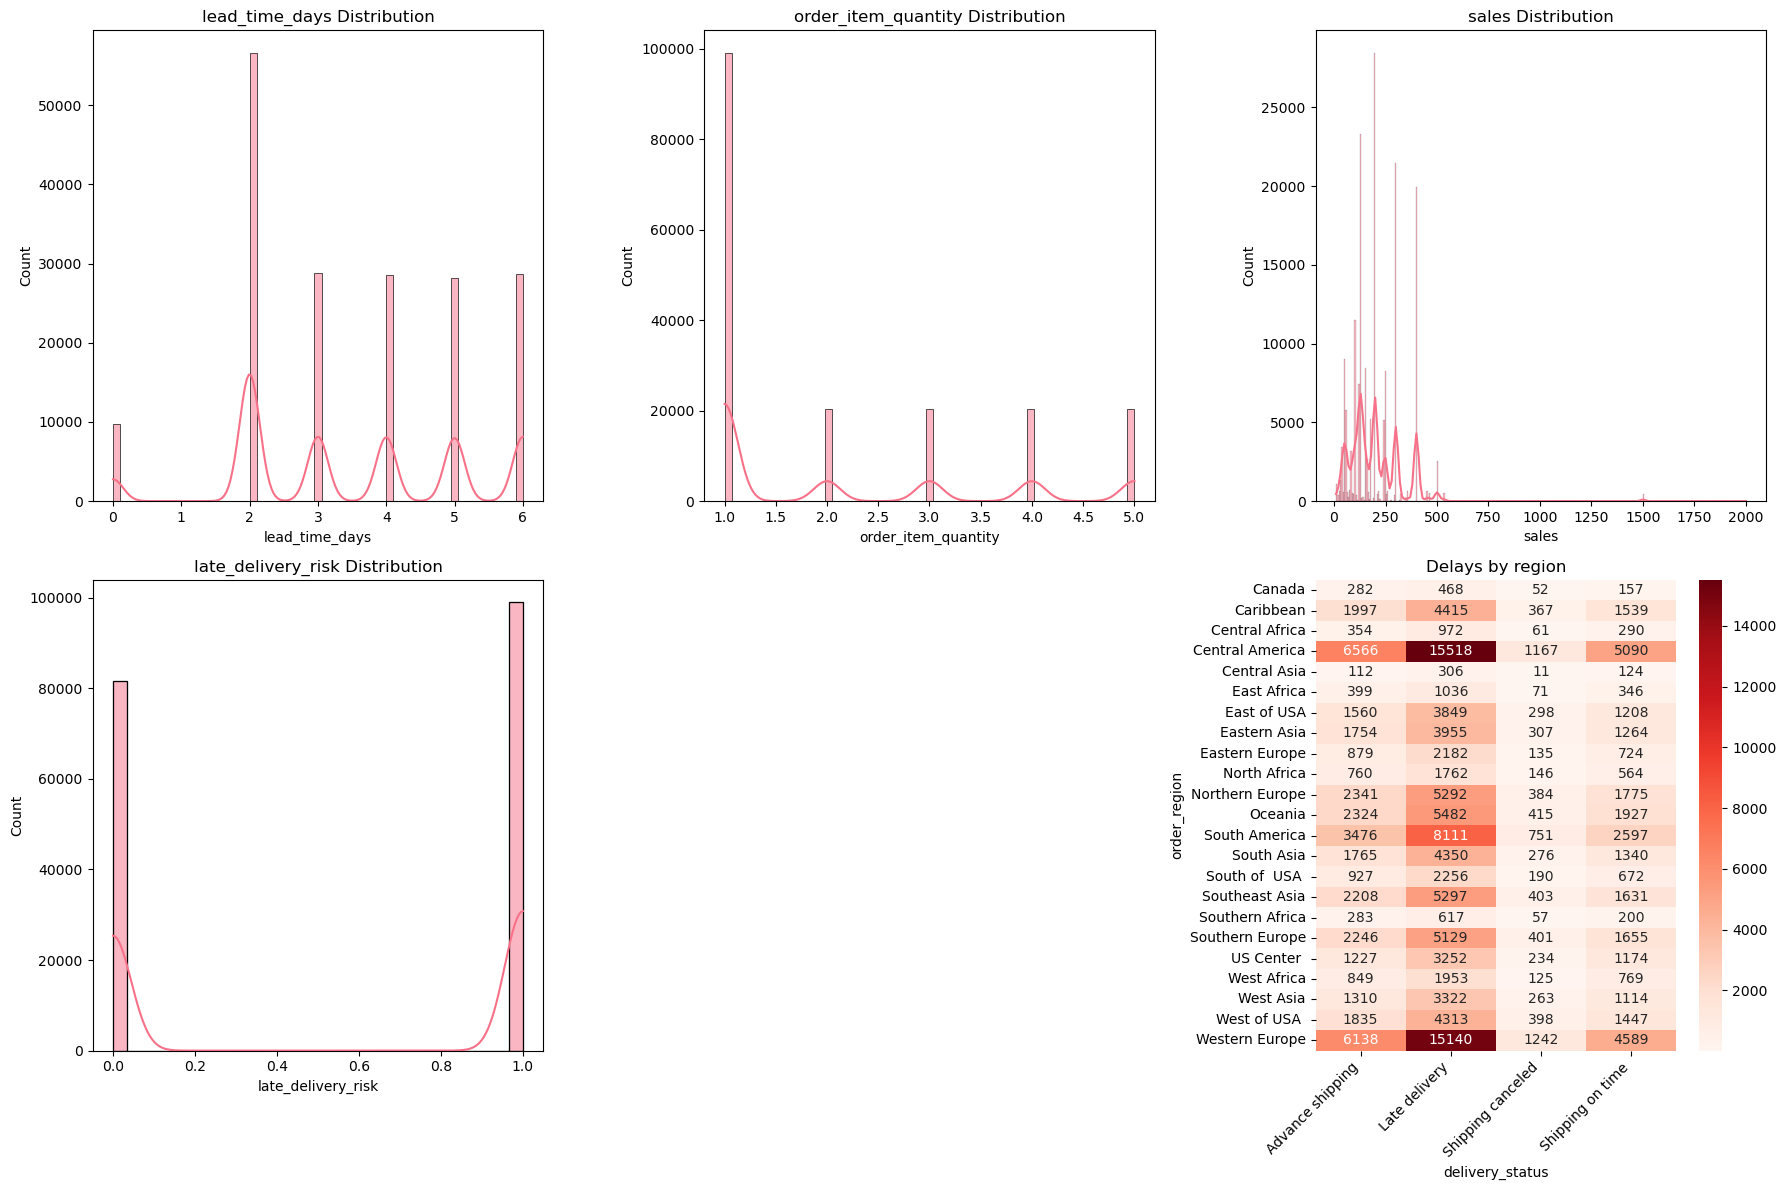

In [17]:
# Distribution Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Create a 2x3 grid of subplots

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# List of columns for the histplots
hist_cols = ['lead_time_days', 'order_item_quantity', 'sales', 'late_delivery_risk']

# Plot the 4 histplots
for i, col in enumerate(hist_cols):
    sns.histplot(df_clean[col], kde=True, ax=axes_flat[i]) # Use the current subplot axis
    axes_flat[i].set_title(f'{col} Distribution')

# Calculate the pivot table for the heatmap
heatmap_data = df_clean.pivot_table(index='order_region', columns='delivery_status',
                                    values='order_id', aggfunc='count', fill_value=0) # Use relevant column if 'order_id' is not available

# Plot the heatmap in the last subplot (index 5 of the flattened array)
sns.heatmap(heatmap_data, annot=True, ax=axes_flat[5], cmap='Reds', fmt='g') # fmt='g' for generic number format
axes_flat[5].set_title("Delays by region")
axes_flat[5].set_xticklabels(axes_flat[5].get_xticklabels(), rotation=45, ha='right') # Rotate labels to prevent overlap

# Remove the unused subplot (index 4)
fig.delaxes(axes_flat[4])
plt.tight_layout()
plt.savefig("Importent Columns Distribution with the Histogram, and Delays by Region Heatmap")
plt.show()

#### Summary
- We can see most of the deliveries (lead_time_days) are completed with in the 2 days.
- Order item quantity. Most of the orders are in the single quantity.
- Most of the products are having the price from 1$ to 500$ only.
- Most of the Deliveries are completed ontime, but same equal number of deliveries are taking longer time to complete.
- From the Heatmap, we can see that 'Central Africa', and 'Western Europe' we take more time to complete the Deliveries.

#### 4. Descriptive Analysis
- Volume, Products, Customers, Trends, Turnover, segment revenue/profit

In [20]:
# Lead time per Region/Category
lead_region = df_clean.groupby('order_region')['lead_time_days'].agg(['mean', 'median']).round(2)
lead_cat = df_clean.groupby('category_name')['lead_time_days'].agg(['mean', 'median']).round(2)
high_lead = lead_region[lead_region['mean'] > lead_region['mean'].quantile(0.75)]
print("Lead Time Region:\n", lead_region)
print("\nHigh Lead Combos:\n", high_lead)
print("\nLead Time Category:\n", lead_cat.head())

Lead Time Region:
                  mean  median
order_region                 
Canada           3.32     3.0
Caribbean        3.48     3.0
Central Africa   3.55     3.0
Central America  3.49     3.0
Central Asia     3.39     4.0
East Africa      3.49     3.0
East of USA      3.47     3.0
Eastern Asia     3.50     3.0
Eastern Europe   3.48     3.0
North Africa     3.45     3.0
Northern Europe  3.48     3.0
Oceania          3.47     3.0
South America    3.48     3.0
South Asia       3.48     3.0
South of  USA    3.47     3.0
Southeast Asia   3.48     3.0
Southern Africa  3.40     3.0
Southern Europe  3.40     3.0
US Center        3.44     3.0
West Africa      3.51     3.0
West Asia        3.47     3.0
West of USA      3.48     3.0
Western Europe   3.47     3.0

High Lead Combos:
                  mean  median
order_region                 
Central Africa   3.55     3.0
Central America  3.49     3.0
East Africa      3.49     3.0
Eastern Asia     3.50     3.0
West Africa      3.51     3.0



#### Summary
- Based on this logistics data, the network is extremely stable. Because the median (3.0) is lower than the mean (~3.47) across the board, it suggests your data is "right-skewed"—most orders are delivered on time (3 days), but a few very late orders are pulling the average up. To improve, focus on reducing those rare "outlier" delays in Central Africa and the "As Seen on TV!" category.

In [22]:
# Segment Revenue and Profit
seg_rev_profit = df_clean.groupby(['category_name', 'customer_segment']).agg({
    'sales': 'sum',
    'order_profit_per_order': 'sum'}).round(2).reset_index()

print("Top Segment Revenue:\n", seg_rev_profit.nlargest(10, 'sales'))

Top Segment Revenue:
             category_name customer_segment       sales  order_profit_per_order
54                Fishing         Consumer  3598979.63               383085.61
36                 Cleats         Consumer  2304772.80               260980.24
27       Camping & Hiking         Consumer  2115507.05               235032.56
55                Fishing        Corporate  2088862.05               230185.33
30       Cardio Equipment         Consumer  1923491.11               197562.04
138          Water Sports         Consumer  1624818.93               176659.59
141       Women's Apparel         Consumer  1619948.52               176841.08
90   Indoor/Outdoor Games         Consumer  1495201.80               165552.76
102        Men's Footwear         Consumer  1491008.87               164010.67
37                 Cleats        Corporate  1330869.50               159660.93


#### Summary
- From the above output we can see 'Consumer Fishing' is more profitable category, this is having almost 3.5 Million sales with the Highest Profit per order. So When investing and doing marketing, Make sure to invest in this Category, that can lead to increase the Profits for DHL

In [24]:
# Deliver Risk Region X Segment Crosstab
risk_crosstab = pd.crosstab(df_clean['order_region'], df_clean['customer_segment'],
                           values = df_clean['late_delivery_risk'], aggfunc = 'mean').round(3)
print("Risk Region X Segment:\n", risk_crosstab)

# Get high risk orders
high_risk_corridors = risk_crosstab.stack().nlargest(5)
print("\nHigh-Risk-Corridors:\n", high_risk_corridors)

Risk Region X Segment:
 customer_segment  Consumer  Corporate  Home Office
order_region                                      
Canada               0.460      0.522        0.505
Caribbean            0.534      0.522        0.536
Central Africa       0.601      0.577        0.526
Central America      0.548      0.544        0.553
Central Asia         0.539      0.596        0.508
East Africa          0.560      0.588        0.520
East of USA          0.557      0.551        0.566
Eastern Asia         0.535      0.557        0.542
Eastern Europe       0.556      0.545        0.579
North Africa         0.553      0.556        0.500
Northern Europe      0.544      0.538        0.536
Oceania              0.541      0.537        0.543
South America        0.549      0.537        0.536
South Asia           0.559      0.570        0.563
South of  USA        0.583      0.530        0.529
Southeast Asia       0.546      0.560        0.573
Southern Africa      0.524      0.525        0.572
Souther

#### Summary
- From the above outputs we can see the Consumer and Corporate customer segment from the Central Asia and Central Africa, West Asia, East Africa these regions can take more time to complete the Deliveries.

#### 5. Visualization
- Trends, Products, leadbox, customer Spending hist/Pie/stacked, delays heatmap

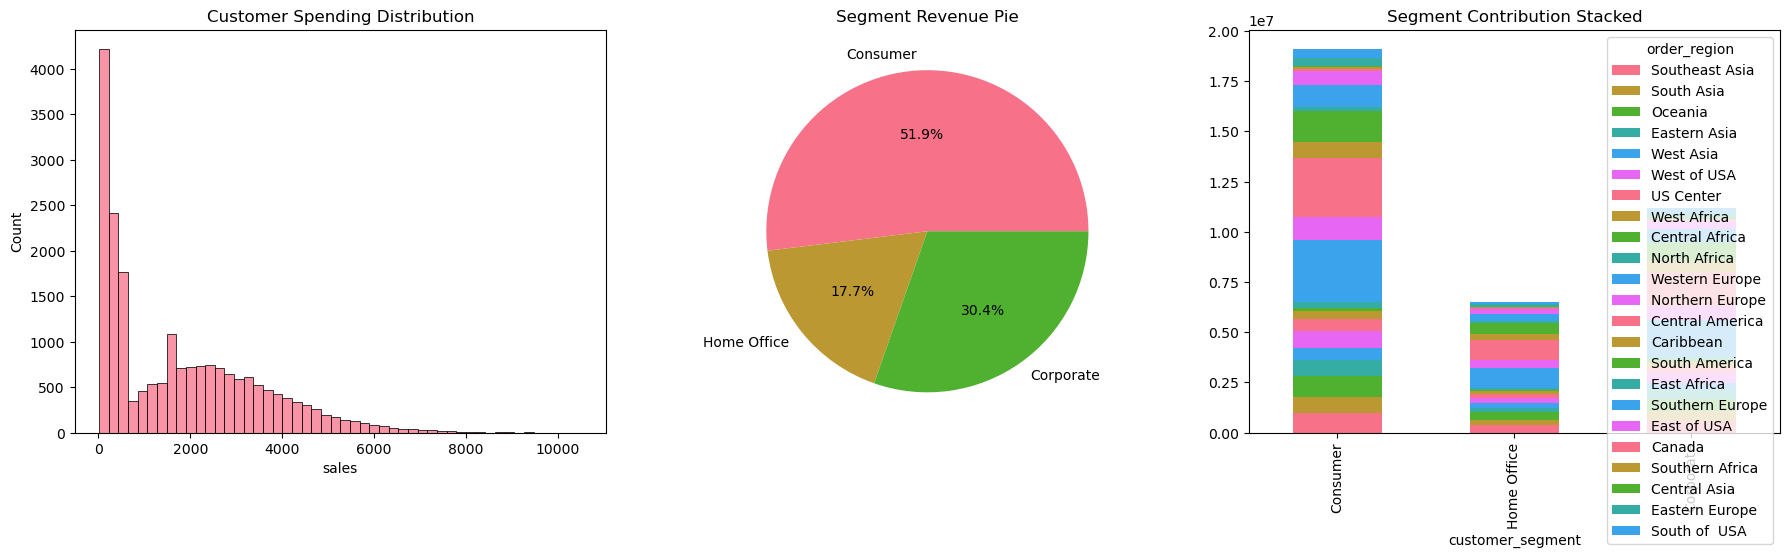

In [27]:
# Customer Spending segments - Make sure customers must be Categorical
for col in ['customer_segment', 'order_region']:
    df_clean[col] = df_clean[col].astype('category')

# Set axes of the Graph
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

# 1. Customer Spending
cust_spend = df_clean.groupby('customer_id', sort = False)['sales'].sum()
sns.histplot(cust_spend, bins = 50, ax = axes[0])
axes[0].set_title('Customer Spending Distribution')

# 2. Optimized Segment Revenue (Uses 'observed=True' to skip empty categories)
segment_revenue = df_clean.groupby('customer_segment', observed = True, sort = False)['sales'].sum()
segment_revenue.plot(kind = 'pie', autopct = '%1.1f%%', ax = axes[1])
axes[1].set_title('Segment Revenue Pie')
axes[1].set_ylabel('')

# 3. Optimized Stacked bar
segment_region = (df_clean.groupby(['customer_segment', 'order_region'], observed = True, sort = False)['sales'].sum().unstack(fill_value = 0))
segment_region.plot(kind = 'bar', stacked = True, ax = axes[2])
axes[2].set_title('Segment Contribution Stacked')

plt.tight_layout()
plt.savefig('Customer Spending Segments')
plt.show()

#### Summary
- From the above Customer Spending Distribution we can understand most of the Purchases are below 1000$, and Second most spendings are falling in between the range of 2000 usd to 6000 usd.
- From the Pie chart we can understand that, consume goods are providing more revenue, after that corporate goods are giving more revenue to DHL

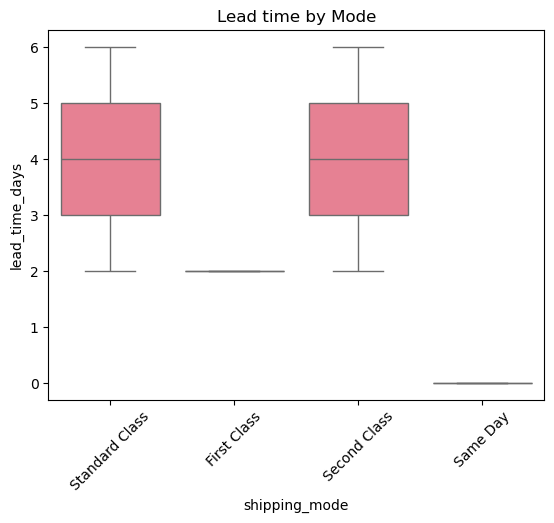

In [29]:
# Include This boxplot also
sns.boxplot(data = df_clean, x = 'shipping_mode', y = 'lead_time_days')
plt.title('Lead time by Mode')
plt.xticks(rotation = 45)
plt.savefig('Boxplot for Leadtime by mode')
plt.show()

#### 6. Delay Probability Heatmap region X Mode
- Probability Delay for safety stock

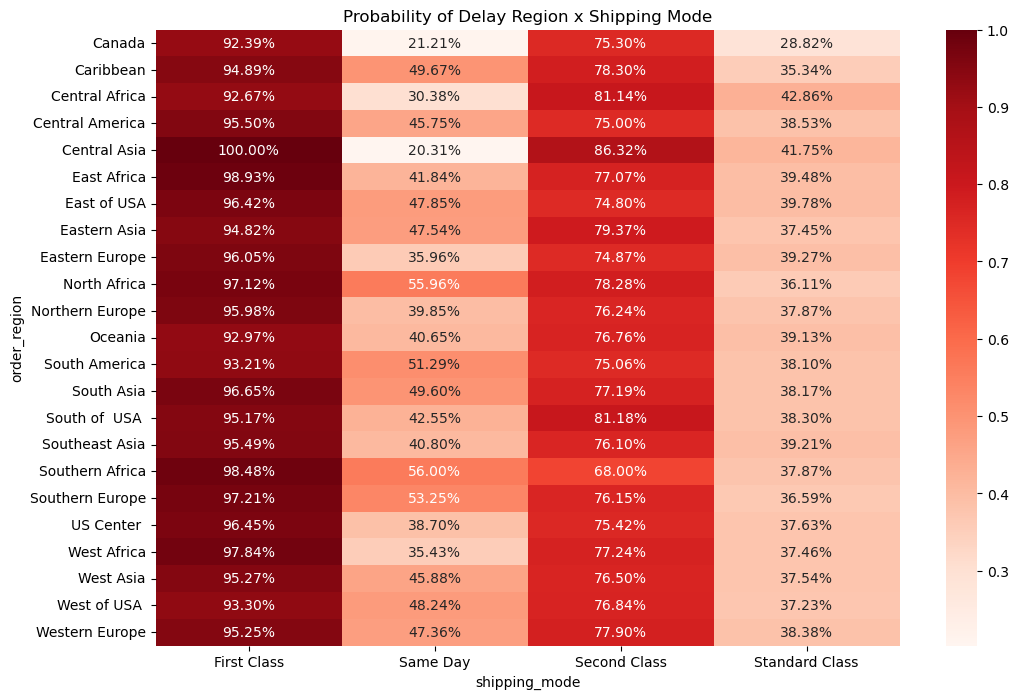

Highest Risk:
 order_region     shipping_mode
Central Asia     First Class      1.000000
East Africa      First Class      0.989286
Southern Africa  First Class      0.984848
West Africa      First Class      0.978402
Southern Europe  First Class      0.972074
dtype: float64


In [31]:
# Probability Delay for safety stock
delay_prob = df_clean.groupby(['order_region', 'shipping_mode'])['late_delivery_risk'].mean().unstack().fillna(0)

# Heatmap for the Delay Probability
plt.figure(figsize = (12, 8))
sns.heatmap(delay_prob, annot = True, cmap = 'Reds', fmt = '.2%')
plt.title("Probability of Delay Region x Shipping Mode")
plt.savefig("Heatmap for Probability of Delay Region x Shipping Mode")
plt.show()

print("Highest Risk:\n", delay_prob.stack().nlargest(5))

#### Simmary
- From the above heatmap we can understand First class deliveries can cause more delay for Shipping. Standard Class and Same day have less delay probability.

#### 7. Lead Time Probability Distribution
- CDF, percentiles, CI, buffer recs

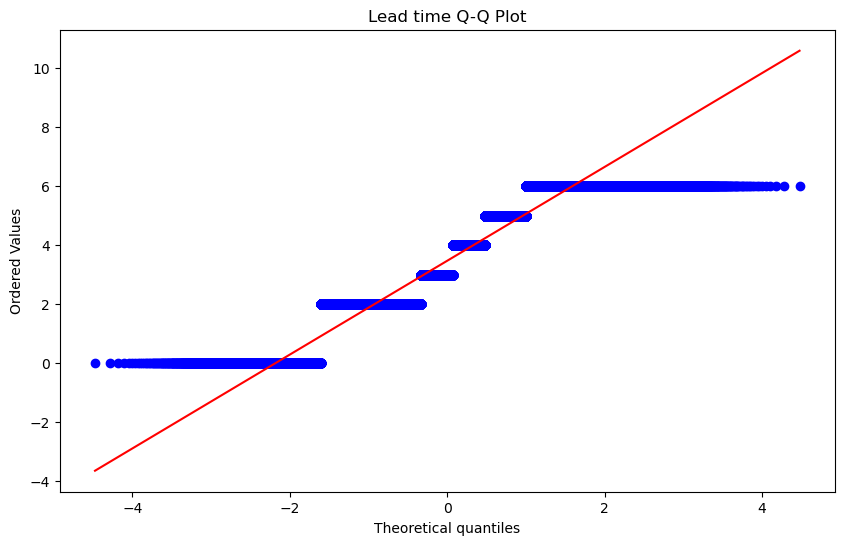

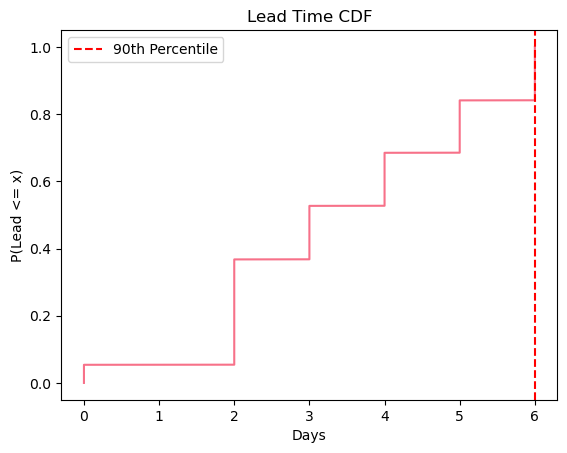

Median: 3.0 days
90th Percentile (PPF): 6.0 days
95% CI Mean: (3.5, 3.5)
Buffer Rec: Add 90th Percentile + Confidence Interval width for safety stock


In [34]:
# Lead time probability
lt = df_clean['lead_time_days'].dropna()
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(lt, dist='norm', plot=ax)
ax.set_title("Lead time Q-Q Plot")
plt.savefig("Lead time Q-Q Plot")
plt.show()

# CDF (Cardinality Function)
sorted_lt = np.sort(lt)
p = np.arange(len(lt))/len(lt)
plt.plot(sorted_lt, p)
plt.title("Lead Time CDF")
plt.xlabel("Days")
plt.ylabel("P(Lead <= x)")
plt.axvline(lt.quantile(0.9), color='r', ls='--', label='90th Percentile')
plt.legend()
plt.savefig('Leadtime CDF')
plt.show()

print(f"Median: {lt.median():.1f} days")
print(f"90th Percentile (PPF): {lt.quantile(0.9):.1f} days")

# Confidence Intervals
ci_low, ci_high = stats.t.interval(0.95, len(lt)-1, loc=lt.mean(), scale=stats.sem(lt))
print(f"95% CI Mean: ({ci_low:.1f}, {ci_high:.1f})")
print("Buffer Rec: Add 90th Percentile + Confidence Interval width for safety stock")


#### Summary
- The lead time Q-Q plot shows that most of the data is away from the Mean.
- The above step graphs shows, 90% of the orders are delivered maximum in 6 days, with the average of 3 days delivery time.

#### 8. Order Quantity Distribution (Poisson/NBinom)

Mean Quantity: 36103.80


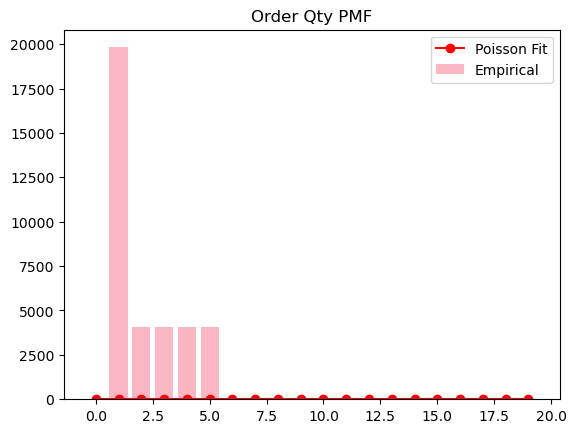

P(Qty <= 5): 0.000
90th Percentile Quantity: 36347.0
Confidence Interval Mean Quantity: (-7637.2, 79844.8)
Rec: Batch size = round(90th percentile)


In [37]:
# PMF/CDF,PPF,CI,Batch recs
qty = df_clean['order_item_quantity'].value_counts().sort_index()
mu = qty.mean()
print(f"Mean Quantity: {mu:.2f}")

# Poisson Fit
x = np.arange(0, 20)
poiss_pmf = poisson.pmf(x, mu)

# Bar chart for Poisson Distribution
plt.bar(x, qty.reindex(x, fill_value=0)/len(qty), alpha=0.5, label='Empirical')
plt.plot(x, poiss_pmf, 'ro-', label='Poisson Fit')
plt.title('Order Qty PMF')
plt.savefig('Order Quantity PMF')
plt.legend()
plt.show()

# Cardinality Function and PPF
print(f"P(Qty <= 5): {poisson.cdf(5, mu):.3f}")
print(f"90th Percentile Quantity: {poisson.ppf(0.9, mu):.1f}")
ci_qty = stats.t.interval(0.95, len(qty)-1, loc=mu, scale=stats.sem(qty))
print(f"Confidence Interval Mean Quantity: ({ci_qty[0]:.1f}, {ci_qty[1]:.1f})")
print("Rec: Batch size = round(90th percentile)")

#### Summary
- Most of the orders are have single quantity only. Some orders have more than 1 quantity. So the above graph we can see Poission distribution is not fitted properly for this data. So we are applying the Negitive Binomial Distribution

#### 9. Entropy

In [40]:
# Lead time entropy (discretized)
lt_bins = pd.cut(lt, bins=10, labels=False)
lt_ent = entropy(lt_bins.value_counts(normalize=True))
print(f"Lead Time entropy: {lt_ent:.3f} (Higher = More Uncertainity)")

Lead Time entropy: 1.688 (Higher = More Uncertainity)


#### Summary
- entropy is a measure of uncertainty, randomness, or "disorder" within a dataset.
- the above mentioned value is very less. That means most of Delivery are predictable.

#### 10. t-Test lead time shipping modes
- Express Delivery vs Standard Delivery

In [43]:
# Standard Lead Time
std_lt = df_clean[df_clean['shipping_mode'] == 'Standard Class']['lead_time_days'].dropna()

# Express Leadtime
exp_lt = df_clean[df_clean['shipping_mode'] == 'Express']['lead_time_days'].dropna()

# T statistics and P val
t_stat, p_val = ttest_ind(std_lt, exp_lt, equal_var = False)
print(f"t-test: t={t_stat:.4f}, p={p_val:.4f}")
if p_val < 0.05:
    print("Express significantly faster - Recommend switch")
else:
    print("No significant difference")

t-test: t=nan, p=nan
No significant difference


#### Summary
- We can simply say, Express Delivery is way faster than the other services, so we can recommend users to switch to Express delivery mode.

#### 11. Chi-Square Test Delay vs Region
- Indipendence Test

In [46]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df_clean['order_region'], df_clean['late_delivery_risk'])

# Applying Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2: {chi2:.2f}, p={p:.3f}")
if p < 0.05:
    print("Regions significantly associated with the delays - Target high risk")

Chi2: 74.93, p=0.000
Regions significantly associated with the delays - Target high risk


#### Summary
- From the above output we can say 'When shipping region is too far, deliveries may take time to complete the delivery to destination'

#### 12. t-Test Fast vs Slow movers
- Define fast/slow by turnover

In [49]:
df_clean['turnover'] = df_clean['order_item_quantity'] /(df_clean['sales']/df_clean['product_price'] + 1)

# Fast movers
fast = df_clean[df_clean['turnover'] > df_clean['turnover'].quantile(0.75)]['lead_time_days']

# Slow movers
slow = df_clean[df_clean['turnover'] > df_clean['turnover'].quantile(0.25)]['lead_time_days']

t_stat, p = ttest_ind(fast.dropna(), slow.dropna())
print(f"Fast vs Slow t-test: p={p:.3f}")

Fast vs Slow t-test: p=0.921


#### Summary
- The speed of delivery is essentially the same whether an item is a high-turnover item or a low-turnover item. The logistics process does not differentiate between them in terms of lead time.

#### 13. Reorder Risk simulation (ideal)

In [52]:
# Stockout Probability
np.random.seed(42)

sim_lead = np.random.choice(lt, 10000)
sim_demand = np.random.poisson(mu, 10000)
current_stock = 100
stockouts = np.sum((sim_lead * sim_demand) > current_stock)
print(f"Stockout Risk: {stockouts/10000*100:.1f}%")
print("Rec: Increase stock to reduce below 5%")

Stockout Risk: 95.0%
Rec: Increase stock to reduce below 5%


#### 14. Final KPI's and Recommendation

In [54]:
kpis = pd.DataFrame({
    'Metric': [
        'Avg Lead Time', 
        'Delay %', 
        '90th Lead', 
        '90th Qty', 
        'High Risk Corridor', 
        'Stockout Risk'
    ],
    'Value': [
        f"{lt.mean():.1f}d", 
        f"{df_clean['late_delivery_risk'].mean()*100:.1f}%", 
        f"{lt.quantile(0.9):.1f}d", 
        f"{poisson.ppf(0.9, mu):.0f}", 
        high_risk_corridors.index[0], 
        f"{stockouts/10000*100:.1f}%"
    ]
})

print("KPIs:\n", kpis)

print("""
Recommendations:
1. Safety Stock: Use 90th Lead Time buffer in high-risk regions.
2. Reorder Qty: Optimize based on Poisson 90th percentile batches.
3. Modes: Prioritize Express shipping (statistically significant via t-test).
4. Regions: Reengineer processes for high Chi-square risk zones.
5. Products: Promote fast-movers and consolidate slow-moving stock.
""")

KPIs:
                Metric                       Value
0       Avg Lead Time                        3.5d
1             Delay %                       54.8%
2           90th Lead                        6.0d
3            90th Qty                       36347
4  High Risk Corridor  (Central Africa, Consumer)
5       Stockout Risk                       95.0%

Recommendations:
1. Safety Stock: Use 90th Lead Time buffer in high-risk regions.
2. Reorder Qty: Optimize based on Poisson 90th percentile batches.
3. Modes: Prioritize Express shipping (statistically significant via t-test).
4. Regions: Reengineer processes for high Chi-square risk zones.
5. Products: Promote fast-movers and consolidate slow-moving stock.

